<a href="https://colab.research.google.com/github/MiguelDantasdeOliveira/Trabalho-POO/blob/master/Clusterizacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='blue'>ML Não Supervisionado - Machine Learning Clusterização</font>

# <font color='blue'>Agrupamento de Clientes Por Consumo de Energia</font>

A partir de dados de consumo de energia de clientes, nosso trabalho é agrupar os consumidores por similaridade a afim de compreender o comportamento dos clientes e sua relação com o consumo de energia.

Arquivo de dados: https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# Carregando os dados
dataset = pd.read_csv('consumo_energia.txt', delimiter = ';')

In [3]:
# Visualizando informações sobre o dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [4]:
dataset.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [5]:
dataset.shape

(2075259, 9)

In [8]:
dataset.dtypes

,0
Date,object
Time,object
Global_active_power,object
Global_reactive_power,object
Voltage,object
Global_intensity,object
Sub_metering_1,object
Sub_metering_2,object
Sub_metering_3,float64


In [9]:
# Checando se há valores missing
dataset.isnull().values.any()

np.True_

In [10]:
# Remove os registros com valores NA e remove as duas primeiras colunas (não são necessárias)
dataset = dataset.iloc[0:, 2:9].dropna()

In [11]:
dataset['Voltage'] = dataset['Voltage'].astype(dtype = 'float64')
dataset['Global_active_power'] = dataset['Global_active_power'].astype(dtype = 'float64')
dataset['Global_reactive_power'] = dataset['Global_reactive_power'].astype(dtype = 'float64')
dataset['Global_intensity'] = dataset['Global_intensity'].astype(dtype = 'float64')
dataset['Sub_metering_1'] = dataset['Sub_metering_1'].astype(dtype = 'float64')
dataset['Sub_metering_2'] = dataset['Sub_metering_2'].astype(dtype = 'float64')
dataset['Sub_metering_3'] = dataset['Sub_metering_3'].astype(dtype = 'float64')

In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2049280 entries, 0 to 2075258
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 125.1 MB


In [13]:
dataset.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [14]:
# Checando se há valores missing
dataset.isnull().values.any()

np.False_

In [15]:
# Obtém os valores dos atributos. Neste caso as variaveis foram carregadas como categorias (object) entao iremos extrair os valores...
dataset_atrib = dataset.values

In [16]:
dataset_atrib

array([[  4.216,   0.418, 234.84 , ...,   0.   ,   1.   ,  17.   ],
       [  5.36 ,   0.436, 233.63 , ...,   0.   ,   1.   ,  16.   ],
       [  5.374,   0.498, 233.29 , ...,   0.   ,   2.   ,  17.   ],
       ...,
       [  0.938,   0.   , 239.82 , ...,   0.   ,   0.   ,   0.   ],
       [  0.934,   0.   , 239.7  , ...,   0.   ,   0.   ,   0.   ],
       [  0.932,   0.   , 239.55 , ...,   0.   ,   0.   ,   0.   ]])

In [17]:
# Coleta uma amostra de 1% dos dados para não comprometer a memória do computador
amostra1, amostra2 = train_test_split(dataset_atrib, train_size = .01)

In [18]:
amostra1.shape

(20492, 7)

In [19]:
# Aplica redução de dimensionalidade
# Transforma as 7 variáveis em 2 variaveis principais. Esse método utiliza Algebra Linear pra identificar semelhança
# entre os dados e assim "juntar" as variaveis, medindo a semelhança pela variância.
pca = PCA(n_components = 2).fit_transform(amostra1)

In [20]:
# Determinando um range de K
k_range = range(1,12)

In [21]:
# Aplicando o modelo K-Means para cada valor de K (esta célula pode levar bastante tempo para ser executada)
k_means_var = [KMeans(n_clusters = k).fit(pca) for k in k_range]

In [22]:
# Ajustando o centróide do cluster para cada modelo
centroids = [X.cluster_centers_ for X in k_means_var]

In [23]:
# Calculando a distância euclidiana de cada ponto de dado para o centróide
k_euclid = [cdist(pca, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke, axis = 1) for ke in k_euclid]

In [24]:
# Soma dos quadrados das distâncias dentro do cluster
soma_quadrados_intra_cluster = [sum(d**2) for d in dist]

In [25]:
# Soma total dos quadrados
soma_total = sum(pdist(pca)**2)/pca.shape[0]

In [26]:
# Soma dos quadrados entre clusters
soma_quadrados_inter_cluster = soma_total - soma_quadrados_intra_cluster

Text(0.5, 1.0, 'Variância Explicada x Valor de K')

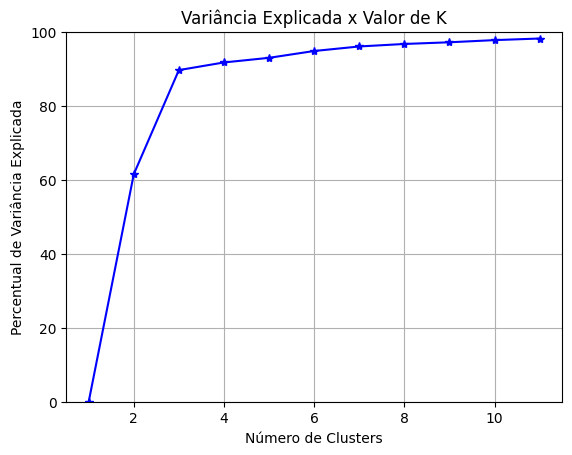

In [27]:
# Curva de Elbow
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, soma_quadrados_inter_cluster/soma_total * 100, 'b*-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('Número de Clusters')
plt.ylabel('Percentual de Variância Explicada')
plt.title('Variância Explicada x Valor de K')

In [29]:
# Criando um modelo com K = 8
modelo_v1 = KMeans(n_clusters = 8)
modelo_v1.fit(pca)

KMeans()

In [30]:
# Obtém os valores mínimos e máximos e organiza o shape
x_min, x_max = pca[:, 0].min() - 5, pca[:, 0].max() - 1
y_min, y_max = pca[:, 1].min() + 1, pca[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = modelo_v1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

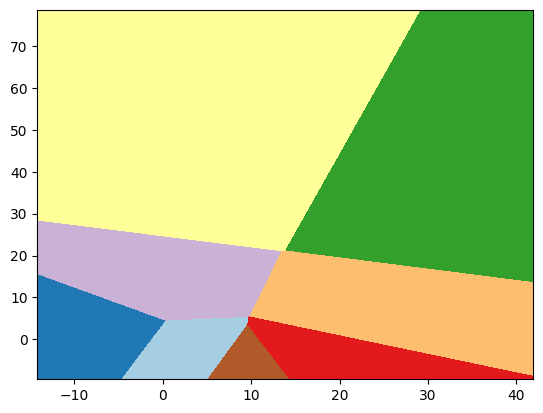

In [32]:
# Plot das áreas dos clusters
plt.figure(1)
plt.clf()
plt.imshow(Z,
           interpolation = 'nearest',
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Paired,
           aspect = 'auto',
           origin = 'lower')

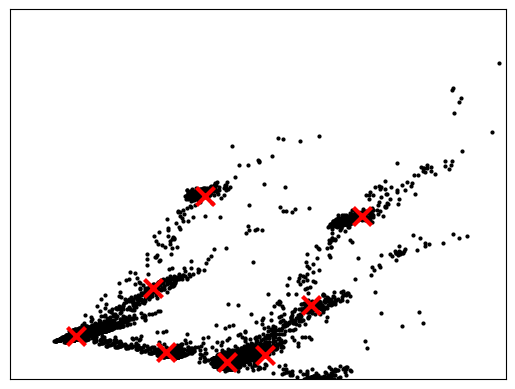

In [34]:
# Plot dos centróides
plt.plot(pca[:, 0], pca[:, 1], 'k.', markersize = 4)
centroids = modelo_v1.cluster_centers_
inert = modelo_v1.inertia_
plt.scatter(centroids[:, 0], centroids[:, 1], marker = 'x', s = 169, linewidths = 3, color = 'r', zorder = 8)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [35]:
#?silhouette_score

In [36]:
# Silhouette Score
labels = modelo_v1.labels_
silhouette_score(pca, labels, metric = 'euclidean')

np.float64(0.7801668368368301)

In [37]:
# Criando um modelo com K = 10
modelo_v2 = KMeans(n_clusters = 10)
modelo_v2.fit(pca)

KMeans(n_clusters=10)

In [38]:
# Obtém os valores mínimos e máximos e organiza o shape
x_min, x_max = pca[:, 0].min() - 5, pca[:, 0].max() - 1
y_min, y_max = pca[:, 1].min() + 1, pca[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = modelo_v2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

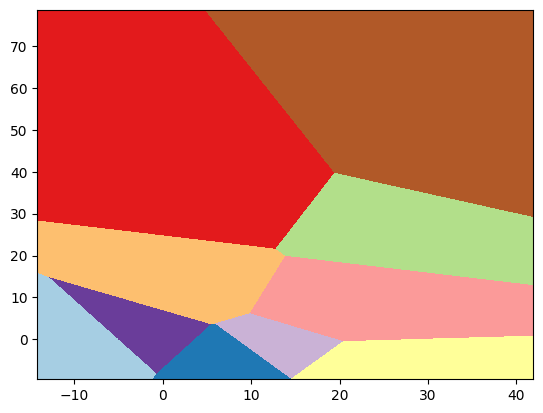

In [39]:
# Plot das áreas dos clusters
plt.figure(1)
plt.clf()
plt.imshow(Z,
           interpolation = 'nearest',
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Paired,
           aspect = 'auto',
           origin = 'lower')

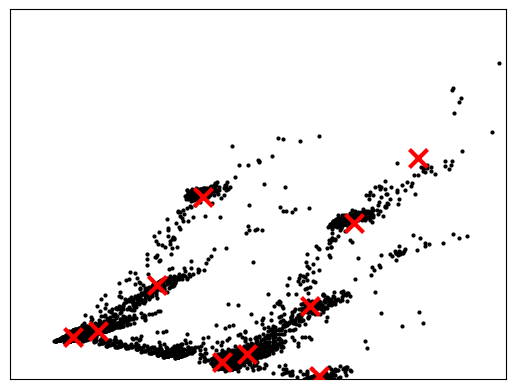

In [40]:
# Plot dos centróides
plt.plot(pca[:, 0], pca[:, 1], 'k.', markersize = 4)
centroids = modelo_v2.cluster_centers_
inert = modelo_v2.inertia_
plt.scatter(centroids[:, 0], centroids[:, 1], marker = 'x', s = 169, linewidths = 3, color = 'r', zorder = 8)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [41]:
# Silhouette Score -- utilizamos para avaliar se o numero de cluster é o ideal... mais proximo de 1 melhor... e -1 pior...
labels = modelo_v2.labels_
silhouette_score(pca, labels, metric = 'euclidean')

np.float64(0.6048033721224794)

Criando o Cluster Map com os clusters do Modelo V1 que apresentou melhor Silhouette Score.

In [42]:
# Lista com nomes das colunas
names = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

In [43]:
# Cria o cluster map
cluster_map = pd.DataFrame(amostra1, columns = names)
cluster_map['Global_active_power'] = pd.to_numeric(cluster_map['Global_active_power'])
cluster_map['cluster'] = modelo_v1.labels_

In [44]:
cluster_map

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,cluster
0,0.212,0.000,250.39,0.8,0.0,0.0,0.0,1
1,4.470,0.108,233.59,19.0,0.0,36.0,18.0,4
2,0.280,0.134,240.97,1.2,0.0,0.0,0.0,1
3,2.302,0.172,237.30,9.6,0.0,0.0,17.0,7
4,0.436,0.080,243.04,2.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...
20487,2.010,0.168,230.04,8.6,0.0,0.0,16.0,7
20488,1.932,0.386,237.33,8.4,0.0,1.0,24.0,3
20489,0.334,0.212,238.27,1.6,0.0,0.0,0.0,1
20490,0.392,0.194,242.84,1.8,0.0,1.0,1.0,1


In [45]:
# Calcula a média de consumo de energia por cluster
cluster_map.groupby('cluster')['Global_active_power'].mean()

,Global_active_power
cluster,
0,1.089178
1,0.508483
2,4.552738
3,3.024412
4,3.927684
5,2.691159
6,3.233092
7,1.631140


In [46]:
# Calcula a quantidade de observacoes por cluster
cluster_map.groupby('cluster')['Global_active_power'].count()

,Global_active_power
cluster,
0,416
1,12808
2,382
3,899
4,266
5,252
6,218
7,5251


### Gerando Cluster com dados normalizados

In [47]:
# Obtém os valores dos atributos. Neste caso as variaveis foram carregadas como categorias (object) entao iremos extrair os valores...
dataset_atrib = dataset.values

# Importa biblioteca para fazer a normalizacao
from sklearn.preprocessing import MinMaxScaler

# Cria o objeto para normalizar e faz a normalizacao dos dados
Padronizador = MinMaxScaler()
dataset_atrib = Padronizador.fit_transform(dataset_atrib)


amostra1, amostra2 = train_test_split(dataset_atrib, train_size = .01)
pca = PCA(n_components = 2).fit_transform(amostra1)
k_range = range(1,12)
k_means_var = [KMeans(n_clusters = k).fit(pca) for k in k_range]
centroids = [X.cluster_centers_ for X in k_means_var]
k_euclid = [cdist(pca, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke, axis = 1) for ke in k_euclid]
soma_quadrados_intra_cluster = [sum(d**2) for d in dist]
soma_total = sum(pdist(pca)**2)/pca.shape[0]
# Soma dos quadrados entre clusters
soma_quadrados_inter_cluster = soma_total - soma_quadrados_intra_cluster
# Criando um modelo com K = 8
modelo_v1 = KMeans(n_clusters = 8)
modelo_v1.fit(pca)
# Obtém os valores mínimos e máximos e organiza o shape
x_min, x_max = pca[:, 0].min() - 5, pca[:, 0].max() - 1
y_min, y_max = pca[:, 1].min() + 1, pca[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = modelo_v1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
# Silhouette Score
labels = modelo_v1.labels_
silhouette_score(pca, labels, metric = 'euclidean')
# Lista com nomes das colunas
names = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

# Cria o cluster map
cluster_map = pd.DataFrame(amostra1, columns = names)
cluster_map['Global_active_power'] = pd.to_numeric(cluster_map['Global_active_power'])
cluster_map['cluster'] = modelo_v1.labels_
cluster_map

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,cluster
0,0.134528,0.070504,0.561874,0.136929,0.011364,0.0250,0.548387,0
1,0.013399,0.000000,0.593861,0.016598,0.000000,0.0000,0.032258,5
2,0.055767,0.053237,0.456866,0.053942,0.000000,0.0000,0.000000,1
3,0.023538,0.066187,0.646850,0.029046,0.000000,0.0000,0.000000,5
4,0.120949,0.000000,0.552504,0.116183,0.000000,0.0000,0.580645,0
...,...,...,...,...,...,...,...,...
20487,0.115155,0.061871,0.467528,0.112033,0.000000,0.0000,0.548387,0
20488,0.061742,0.135252,0.511470,0.062241,0.000000,0.0125,0.000000,1
20489,0.152091,0.112230,0.496607,0.149378,0.000000,0.0250,0.580645,2
20490,0.047619,0.000000,0.617447,0.045643,0.000000,0.0000,0.000000,5


In [48]:
# Calcula da quantidade de observações por cluster
cluster_map.groupby('cluster')['Global_active_power'].count()

,Global_active_power
cluster,
0,4166
1,5703
2,2042
3,157
4,1627
5,5766
6,661
7,370
